In [25]:
# import libraries

import packages.script as script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [26]:
train = pd.read_csv(r"/content/train.csv")
test = pd.read_csv(r"/content/test.csv")

In [27]:
# these columns are not necessary for forecasting sales

train.drop(columns=["id", "lat", "long"], inplace=True)
test.drop(columns=["id", "lat", "long"], inplace=True)

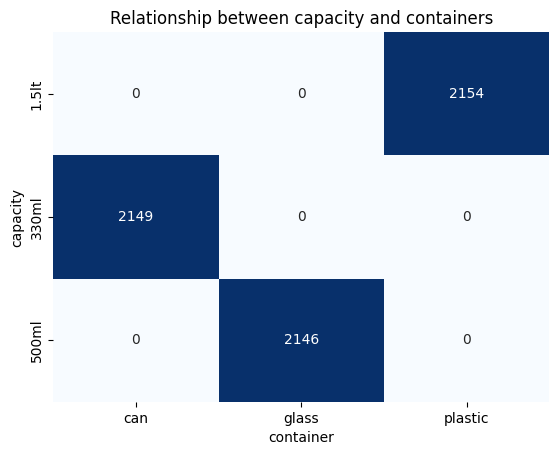

In [28]:
# visualizing relationship between the features container and capacity. Required to impute missing values

mosaic_data = pd.crosstab(train['capacity'], train['container'], margins=False)
sns.heatmap(mosaic_data, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Relationship between capacity and containers")
plt.show()

In [29]:
# creating mappers to fill missing container values from corresponding capacity values and vice versa

capa2cont = {"330ml": "can", "500ml": "glass", "1.5lt": "plastic"}
cont2capa = {v: k for k, v in capa2cont.items()}

def fillnan(df, ffrom, fto, mapper):
    indices = df[df[fto].isna()].index
    for i in indices:
        df[fto].loc[i] = mapper[df[ffrom].loc[i]]

    return df


train = fillnan(train, "capacity", "container", capa2cont)
test = fillnan(test, "capacity", "container", capa2cont)

train = fillnan(train, "container", "capacity", cont2capa)
test = fillnan(test, "container", "capacity", cont2capa)

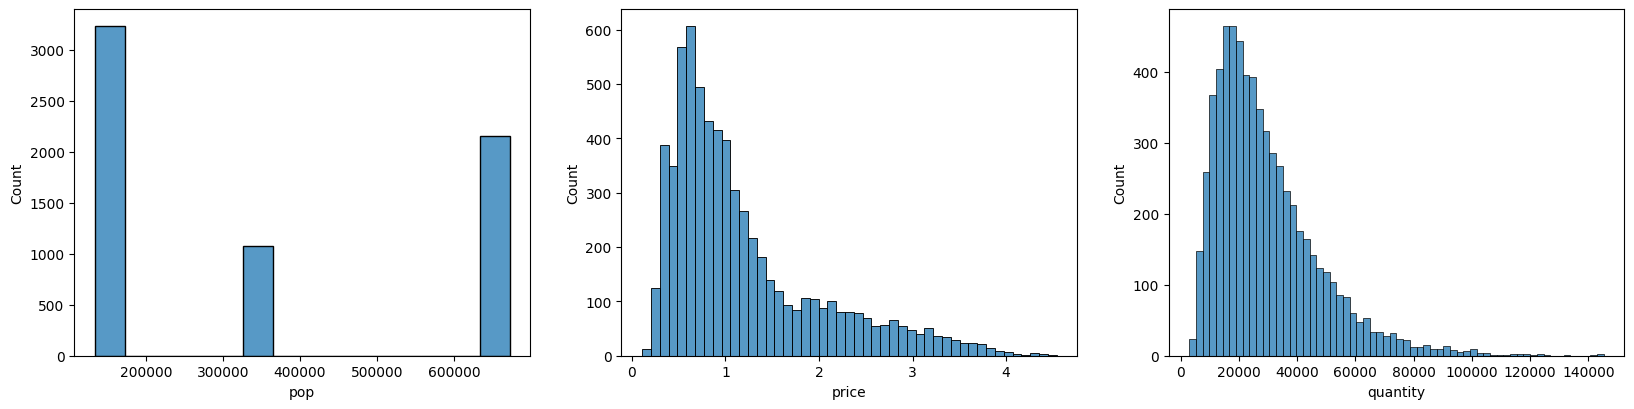

In [30]:
# visualizing distributions of numerical features for scaling down by constant factor

plt.figure(figsize=(20, 4.5))

plt.subplot(1, 3, 1)
sns.histplot(train['pop'])

plt.subplot(1, 3, 2)
sns.histplot(train.price)

plt.subplot(1, 3, 3)
sns.histplot(train.quantity)

plt.show()

In [31]:
# feature engineering and one hot encoding categorical data

categoricals = ["city", "shop", "brand", "item"]
const_scaler = 100000

def process_df(df):

    # scaling down large values by constant factor
    df['pop'] = df['pop'].astype('float32')/const_scaler
    df['quantity'] = df['quantity']/const_scaler


    # joining capacity and containers in single feature because they have 1 to 1 relationship
    df['item'] = df['capacity'] + " " + df['container']
    df.drop(columns=["capacity", "container"], inplace=True)


    df = pd.get_dummies(df, columns=categoricals)

    return df


train = process_df(train)
test = process_df(test)

In [32]:
# standardizing numerical features

numericals = ["pop", "price"]

scaler = StandardScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(train[numericals]), columns=numericals)
scaled_test = pd.DataFrame(scaler.transform(test[numericals]), columns=numericals)

for col in numericals:
    train[col] = scaled_train[col]
    test[col] = scaled_test[col]

In [33]:
# defining features and labels

features = [x for x in train.columns.values if x not in ["date", "quantity"]]
labels = "quantity"

In [53]:
# hyperparameter tuning of model

estimator = XGBRegressor(base_score=0.5, booster='gbtree',
                       early_stopping_rounds=100,
                       objective='reg:squarederror')

n_estimators = np.arange(5, 30, 5)
max_depth = np.arange(5, 10, 1)
learning_rate = [1e-20, 1e-15]
tracker = {}

for nest in n_estimators:
    for md in max_depth:
        for lr in learning_rate:
            param_combo = (nest, md, lr)

            estimator = XGBRegressor(base_score=0.5, booster='gbtree',
                                     early_stopping_rounds=100,
                                     objective='reg:squarederror',
                                     n_estimators=nest,
                                     max_depth=md,
                                     leraning_rate=lr,
                                     )

            scores = []

            obj = script.NestedCV(3)
            splits = obj.split(train, "date")

            for tn, val in splits:

                xtn = tn[features]
                ytn = tn[labels]

                xval = val[features]
                yval = val[labels]

                estimator.fit(xtn, ytn,
                              eval_set=[(xtn, ytn), (xval, yval)],
                              verbose=0)
                yp = estimator.predict(xval)
                mse = np.sqrt(mean_squared_error(yval, yp))
                scores.append(mse)


            print(f"Parameter combo: {(nest, md, lr)} --> Avg. scaled down rmse: {np.round(np.mean(scores), 4)}")

            tracker[(nest, md, lr)] = np.mean(scores)

Parameter combo: (5, 5, 1e-20) --> Avg. scaled down rmse: 0.1039
Parameter combo: (5, 5, 1e-15) --> Avg. scaled down rmse: 0.1039
Parameter combo: (5, 6, 1e-20) --> Avg. scaled down rmse: 0.099
Parameter combo: (5, 6, 1e-15) --> Avg. scaled down rmse: 0.099
Parameter combo: (5, 7, 1e-20) --> Avg. scaled down rmse: 0.0981
Parameter combo: (5, 7, 1e-15) --> Avg. scaled down rmse: 0.0981
Parameter combo: (5, 8, 1e-20) --> Avg. scaled down rmse: 0.1004
Parameter combo: (5, 8, 1e-15) --> Avg. scaled down rmse: 0.1004
Parameter combo: (5, 9, 1e-20) --> Avg. scaled down rmse: 0.1002
Parameter combo: (5, 9, 1e-15) --> Avg. scaled down rmse: 0.1002
Parameter combo: (10, 5, 1e-20) --> Avg. scaled down rmse: 0.0814
Parameter combo: (10, 5, 1e-15) --> Avg. scaled down rmse: 0.0814
Parameter combo: (10, 6, 1e-20) --> Avg. scaled down rmse: 0.0789
Parameter combo: (10, 6, 1e-15) --> Avg. scaled down rmse: 0.0789
Parameter combo: (10, 7, 1e-20) --> Avg. scaled down rmse: 0.0775
Parameter combo: (10, 

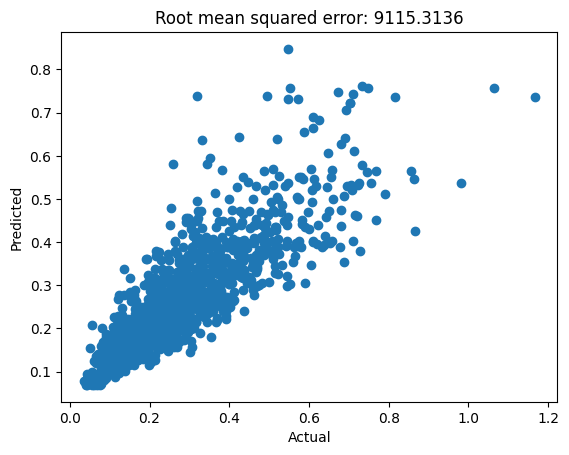

In [54]:
# prediction on entire test set at once

tracker = dict(sorted(tracker.items(), key=lambda x: x[1]))
selected = list(tracker.items())[0][0]

n_est, m_d, l_r = selected

estimator = XGBRegressor(base_score=0.5, booster='gbtree',
                                     objective='reg:squarederror',
                                     n_estimators=n_est,
                                     max_depth=m_d,
                                     leraning_rate=l_r,
                                     )


estimator.fit(train[features], train[labels])

pred = estimator.predict(test[features])
plt.scatter(test[labels], pred)

orig_error = np.sqrt(mean_squared_error(test[labels], pred)) * const_scaler

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Root mean squared error: {round(orig_error, 4)}")
plt.show()


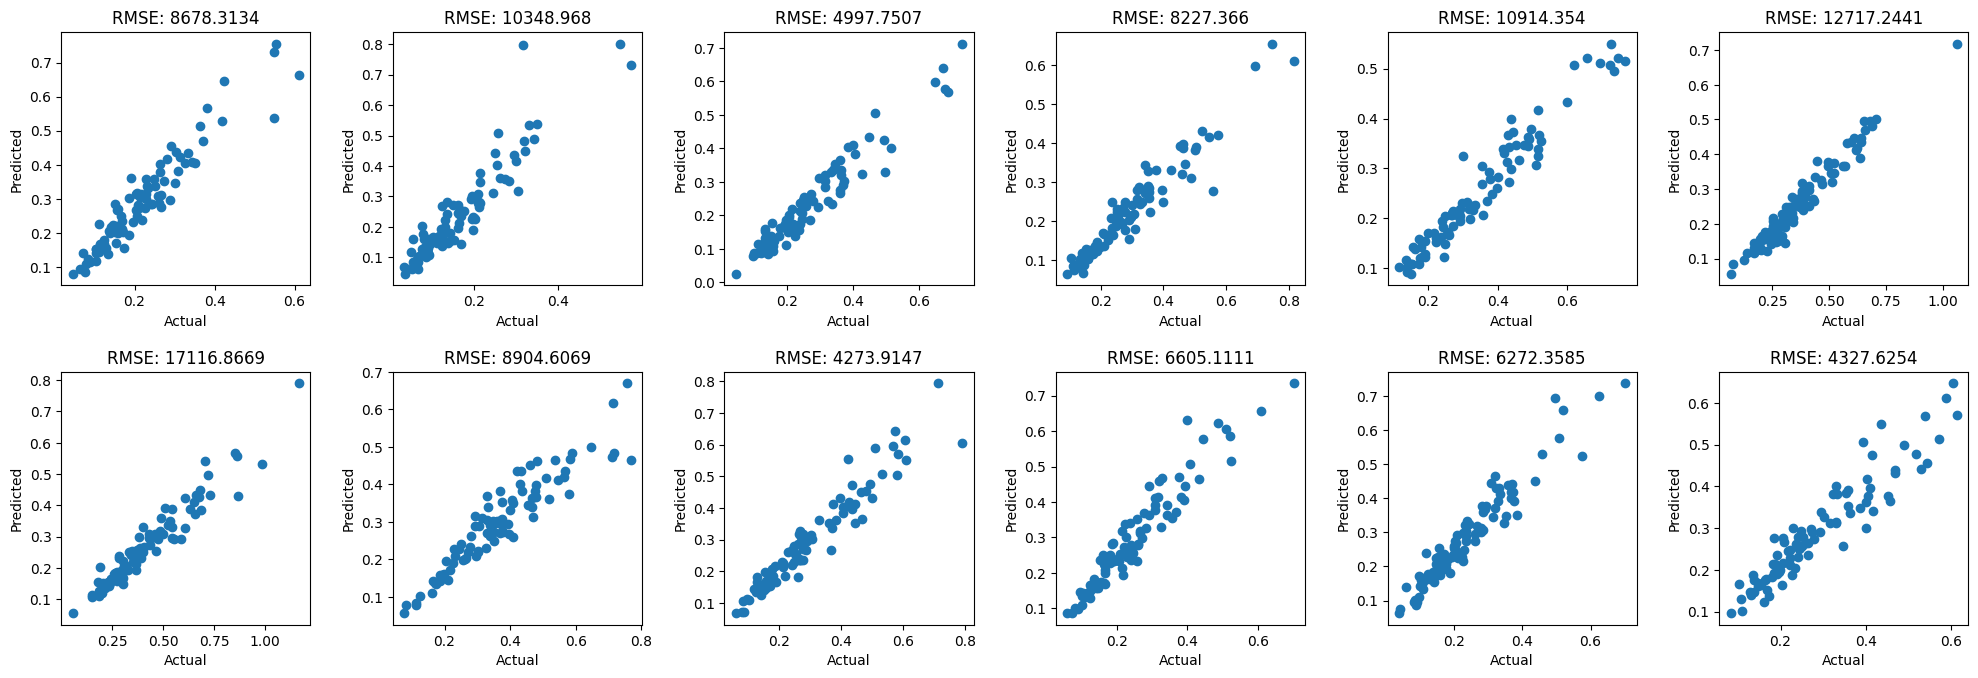

In [56]:
# prediction on unique month ends from test set taking at a time

plt.figure(figsize=(20, 7))
mytrain = train.copy()

for i, d in enumerate(test.date.unique()):
    mytest = test[test['date']==d]

    estimator.fit(mytrain[features], mytrain[labels])

    pred = estimator.predict(mytest[features])
    plt.subplot(2, 6, i+1)
    plt.scatter(mytest[labels], pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    orig_error = np.sqrt(mean_squared_error(mytest[labels], pred)) * const_scaler

    plt.title(f"RMSE: {round(orig_error, 4)}")

    mytrain = pd.concat([mytrain, mytest], ignore_index=True)


plt.tight_layout(pad=1.5)
plt.show()


# Summary



1.   We first visualized the data in the datasets including missing data
2.   We imputed missing data and scaled down large numbers by a constant factor for data modelling.
3.   We standardazid numerical data and one hot encoded categorical data.
4.   We performed hyperparameter tuning of an XGBoost regressor model using the Nested CV splits obtained from NestedCV class.
5.   We evaluated performance of the XGBoost model on the complete test dataset.
6.   Due to the fact that the custom made Nested CV class is programmed to consider a duration of one month for validation splits, the obtained XGBoost model was progressively used to make short term predictions for one month at a time from the test set. For every new month, the previous month was appended to the training data.

